In [175]:
from pathlib import Path
import pandas as pd
import numpy as np

pd.set_option("display.max_columns", 100)

# --- Project paths ---
# Notebook path: <repo>/notebooks/
# Data path:     <repo>/data/
# Outputs path:  <repo>/outputs/
PROJECT_ROOT   = Path.cwd().parent
DATA_RAW       = PROJECT_ROOT / "data"
DATA_PROCESSED = PROJECT_ROOT / "outputs"

TRAIN_FILE = DATA_RAW / "adult.data"
TEST_FILE  = DATA_RAW / "adult.test"  # often has a 1-line header-ish row

DATA_PROCESSED.mkdir(parents=True, exist_ok=True)

print("Project root:", PROJECT_ROOT)
print("Raw data path:", DATA_RAW)
print("Outputs path:", DATA_PROCESSED)
print("Train exists?", TRAIN_FILE.exists(), "| Test exists?", TEST_FILE.exists())

Project root: /Users/kavaughnsmith/FairHire-Analytics
Raw data path: /Users/kavaughnsmith/FairHire-Analytics/data
Outputs path: /Users/kavaughnsmith/FairHire-Analytics/outputs
Train exists? True | Test exists? True


In [176]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, classification_report, confusion_matrix
)
import joblib
import json

In [177]:
def load_adult_file(path: Path, has_header_comment: bool = False) -> pd.DataFrame:
    """
    Loads an Adult-format file while:
    - applying canonical column names
    - reading as strings first (we'll cast later)
    - trimming whitespace
    - optionally skipping the first line if it's a header/comment (adult.test)
    """
    ADULT_COLS = [
        "age","workclass","fnlwgt","education","education_num","marital_status",
        "occupation","relationship","race","sex","capital_gain","capital_loss",
        "hours_per_week","native_country","income"
    ]

    if not path.exists():
        raise FileNotFoundError(f"File not found: {path}")

    skiprows = 1 if has_header_comment else 0

    df = pd.read_csv(
        path,
        header=None,
        names=ADULT_COLS,
        skiprows=skiprows,
        dtype=str,             # treat all as str first
        na_values=None,        # we'll convert '?' explicitly
        skipinitialspace=True, # trim spaces after commas
        engine="python"
    )

    # Strip any remaining whitespace in string cells
    df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)
    return df

In [178]:
train_df_raw = load_adult_file(TRAIN_FILE, has_header_comment=False)
test_df_raw  = load_adult_file(TEST_FILE,  has_header_comment=True)

print("Train shape:", train_df_raw.shape)
print("Test  shape:", test_df_raw.shape)

train_df_raw.head(3)

Train shape: (32561, 15)
Test  shape: (16281, 15)


/var/folders/q6/_ykp3mp51jv22jvl98pfp7lh0000gn/T/ipykernel_44943/3164247407.py:32: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)
/var/folders/q6/_ykp3mp51jv22jvl98pfp7lh0000gn/T/ipykernel_44943/3164247407.py:32: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)


,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K


In [179]:
# Keep split markers (optional but useful)
train_df_raw["_split"] = "train"
test_df_raw["_split"]  = "test"

df = pd.concat([train_df_raw, test_df_raw], axis=0, ignore_index=True)
print("Combined shape:", df.shape)

# Normalize target labels: adult.test uses trailing periods
df["income"] = df["income"].str.replace(".", "", regex=False)

# Standardize missing tokens: treat '?' as NaN
df.replace("?", np.nan, inplace=True)

# Quick sanity checks
print("Unique income labels:", df["income"].unique())
df.head(3)

Combined shape: (48842, 16)
Unique income labels: ['<=50K' '>50K']


,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income,_split
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K,train
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K,train
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K,train


In [180]:
print("Original shape:", df.shape)

# Report missingness before dropping
missing_before = df.isna().sum().sort_values(ascending=False)
print("Missing values (top 10):\n", missing_before.head(10))

# Option A: conservative — drop rows with *any* missing values
df = df.dropna().copy()

print("After dropna shape:", df.shape)

# Sanity: target distribution
print(df["income"].value_counts(normalize=True).rename("income_share"))

Original shape: (48842, 16)
Missing values (top 10):
 occupation        2809
workclass         2799
native_country     857
age                  0
fnlwgt               0
education            0
education_num        0
marital_status       0
relationship         0
race                 0
dtype: int64
After dropna shape: (45222, 16)
income
<=50K    0.752156
>50K     0.247844
Name: income_share, dtype: float64


In [181]:
# Cast numeric columns now that rows with 'NaN' were removed
NUM_COLS = ["age", "fnlwgt", "education_num", "hours_per_week", "capital_gain", "capital_loss"]

for col in NUM_COLS:
    df[col] = pd.to_numeric(df[col], errors="raise")

df.dtypes

age                int64
workclass         object
fnlwgt             int64
education         object
education_num      int64
marital_status    object
occupation        object
relationship      object
race              object
sex               object
capital_gain       int64
capital_loss       int64
hours_per_week     int64
native_country    object
income            object
_split            object
dtype: object

In [182]:
# Sensitive attribute for later fairness work (can change to 'race' later)
SENSITIVE_FEATURE = "sex"

# Build categorical list from object columns, excluding target & sensitive
categorical_cols = df.select_dtypes(include="object").columns.tolist()
for col_to_remove in [SENSITIVE_FEATURE, "income", "_split"]:
    if col_to_remove in categorical_cols:
        categorical_cols.remove(col_to_remove)

numeric_cols = NUM_COLS  # as casted above

print("Categorical:", categorical_cols)
print("Numeric    :", numeric_cols)
print("Sensitive  :", SENSITIVE_FEATURE)

Categorical: ['workclass', 'education', 'marital_status', 'occupation', 'relationship', 'race', 'native_country']
Numeric    : ['age', 'fnlwgt', 'education_num', 'hours_per_week', 'capital_gain', 'capital_loss']
Sensitive  : sex


In [183]:
combined_clean_path = DATA_PROCESSED / "adult_combined_clean.csv"
df.to_csv(combined_clean_path, index=False)
print("Wrote:", combined_clean_path, "| rows:", len(df))

Wrote: /Users/kavaughnsmith/FairHire-Analytics/outputs/adult_combined_clean.csv | rows: 45222


In [184]:
# Recreate original split if you want to keep it aligned with source files
df_train_clean = df[df["_split"] == "train"].drop(columns=["_split"]).reset_index(drop=True)
df_test_clean  = df[df["_split"] == "test"].drop(columns=["_split"]).reset_index(drop=True)

out_train = DATA_PROCESSED / "adult_train_clean.csv"
out_test  = DATA_PROCESSED / "adult_test_clean.csv"

df_train_clean.to_csv(out_train, index=False)
df_test_clean.to_csv(out_test, index=False)

print("Saved:")
print(" -", out_train, "| rows:", len(df_train_clean))
print(" -", out_test,  "| rows:", len(df_test_clean))

Saved:
 - /Users/kavaughnsmith/FairHire-Analytics/outputs/adult_train_clean.csv | rows: 30162
 - /Users/kavaughnsmith/FairHire-Analytics/outputs/adult_test_clean.csv | rows: 15060


In [185]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=["income", "_split"])
y = df["income"].copy()

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Train:", X_train.shape, " Valid:", X_valid.shape)

# Save for modeling step if you like
(X_train.assign(income=y_train)
 .to_csv(DATA_PROCESSED / "model_Xy_train.csv", index=False))
(X_valid.assign(income=y_valid)
 .to_csv(DATA_PROCESSED / "model_Xy_valid.csv", index=False))
print("Wrote model-ready CSVs to:", DATA_PROCESSED)

Train: (36177, 14)  Valid: (9045, 14)
Wrote model-ready CSVs to: /Users/kavaughnsmith/FairHire-Analytics/outputs


In [186]:
try:
    X_train, X_valid, y_train, y_valid  # noqa: F823
except NameError:
    X = df.drop(columns=["income", "_split"])
    y = df["income"].copy()
    X_train, X_valid, y_train, y_valid = train_test_split(
        X, y, test_size=0.20, stratify=y, random_state=42
    )

# Keep the sensitive attribute OUT of the model inputs, but handy for metrics
SENSITIVE_FEATURE = "sex"  # change to 'race' later if you want

sens_train = X_train[SENSITIVE_FEATURE].copy()
sens_valid = X_valid[SENSITIVE_FEATURE].copy()

X_train_nosens = X_train.drop(columns=[SENSITIVE_FEATURE])
X_valid_nosens = X_valid.drop(columns=[SENSITIVE_FEATURE])

print(X_train_nosens.shape, X_valid_nosens.shape)

(36177, 13) (9045, 13)


In [187]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

# One-hot for categoricals; scale numerics (with_mean=False because the matrix is sparse)
ohe = OneHotEncoder(handle_unknown="ignore")
numeric_pipe = Pipeline(steps=[
    ("scaler", StandardScaler(with_mean=False))
])

preprocess = ColumnTransformer(
    transformers=[
        ("cat", ohe, categorical_cols),
        ("num", numeric_pipe, numeric_cols),
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

clf = LogisticRegression(
    solver="lbfgs",
    class_weight="balanced",
    max_iter=1000,   # bumped up for convergence
)

pipe = Pipeline(steps=[
    ("prep", preprocess),
    ("model", clf)
])

pipe


Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['workclass', 'education',
                                                   'marital_status',
                                                   'occupation', 'relationship',
                                                   'race', 'native_country']),
                                                 ('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler(with_mean=False))]),
                                                  ['age', 'fnlwgt',
                                                   'education_num',
                                                   'hours_per_week',
                                                   'capital_gain',
                                                   'capital_loss'])],
                                   verbose_feature_names_out=False)),
                ('model',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

In [188]:
pipe.fit(X_train_nosens, y_train)
print("Trained. Coefficients shape:",
      pipe.named_steps["model"].coef_.shape)

Trained. Coefficients shape: (1, 102)


In [189]:
y_pred = pipe.predict(X_valid_nosens)
y_prob = pipe.predict_proba(X_valid_nosens)[:, 1]  # P(>50K)

# Pick positive label
pos = ">50K"

acc  = accuracy_score(y_valid, y_pred)
prec = precision_score(y_valid, y_pred, pos_label=pos)
rec  = recall_score(y_valid, y_pred,    pos_label=pos)
f1   = f1_score(y_valid, y_pred,        pos_label=pos)
auc  = roc_auc_score((y_valid==pos).astype(int), y_prob)

print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1:        {f1:.4f}")
print(f"ROC AUC:   {auc:.4f}\n")

print("Classification report:")
print(classification_report(y_valid, y_pred))

print("Confusion matrix:")
print(confusion_matrix(y_valid, y_pred, labels=["<=50K", ">50K"]))

Accuracy:  0.8091
Precision: 0.5798
Recall:    0.8345
F1:        0.6842
ROC AUC:   0.9015

Classification report:
              precision    recall  f1-score   support

       <=50K       0.94      0.80      0.86      6803
        >50K       0.58      0.83      0.68      2242

    accuracy                           0.81      9045
   macro avg       0.76      0.82      0.77      9045
weighted avg       0.85      0.81      0.82      9045

Confusion matrix:
[[5447 1356]
 [ 371 1871]]


In [190]:
from collections import defaultdict

def group_rates(y_true, y_pred, positive=pos):
    """
    Returns per-group confusion-derived rates for the sensitive attribute present
    in `sens_valid` (captured from outer scope).
    """
    # Build frame so we can groupby sensitive attribute
    tmp = pd.DataFrame({
        "y_true": y_true,
        "y_pred": y_pred,
        "group": sens_valid.values
    })

    # Ensure binary ints for convenience
    tmp["yt"] = (tmp["y_true"] == positive).astype(int)
    tmp["yp"] = (tmp["y_pred"] == positive).astype(int)

    stats = {}
    for g, part in tmp.groupby("group"):
        tp = int(((part["yt"] == 1) & (part["yp"] == 1)).sum())
        fp = int(((part["yt"] == 0) & (part["yp"] == 1)).sum())
        tn = int(((part["yt"] == 0) & (part["yp"] == 0)).sum())
        fn = int(((part["yt"] == 1) & (part["yp"] == 0)).sum())
        p  = tp + fn
        n  = fp + tn

        # Rates
        tpr = tp / p if p else np.nan       # equal opportunity
        fpr = fp / n if n else np.nan
        ppr = (tp + fp) / (p + n) if (p+n) else np.nan  # demographic parity rate
        ppv = tp / (tp + fp) if (tp+fp) else np.nan     # precision per group

        stats[g] = dict(tp=tp, fp=fp, tn=tn, fn=fn, tpr=tpr, fpr=fpr, ppr=ppr, ppv=ppv)
    return pd.DataFrame(stats).T

def disparity_table(rates_df, reference=None):
    """
    Compute disparity vs a reference group (default: the group with highest PPR).
    Provides:
      - Demographic Parity Difference (PPR max - min)
      - Disparate Impact Ratio (PPR_group / PPR_ref)
      - Equal Opportunity (TPR difference vs ref)
      - FPR difference vs ref
      - PPV difference vs ref
    """
    dfm = rates_df.copy()
    if reference is None:
        reference = dfm["ppr"].idxmax()  # ref = highest selection rate

    ref_row = dfm.loc[reference]
    out = dfm.copy()
    out["ppr_diff_vs_ref"] = dfm["ppr"] - ref_row["ppr"]
    out["ppr_ratio_vs_ref"] = dfm["ppr"] / ref_row["ppr"] if ref_row["ppr"] else np.nan
    out["tpr_diff_vs_ref"] = dfm["tpr"] - ref_row["tpr"]
    out["fpr_diff_vs_ref"] = dfm["fpr"] - ref_row["fpr"]
    out["ppv_diff_vs_ref"] = dfm["ppv"] - ref_row["ppv"]
    return out, reference

In [191]:
rates = group_rates(y_valid, y_pred, positive=pos)
disp, ref = disparity_table(rates)

print(f"Sensitive attribute: {SENSITIVE_FEATURE}")
print(f"Reference group (highest selection rate): {ref}\n")
display(rates.round(4))
display(disp.round(4))

# Summary headlines
dp_diff = rates["ppr"].max() - rates["ppr"].min()  # Demographic Parity Difference
di_ratio = (rates["ppr"].min() / rates["ppr"].max()) if rates["ppr"].max() else np.nan
eopp_diff = rates["tpr"].max() - rates["tpr"].min()

print(f"Demographic Parity Difference (PPR max-min): {dp_diff:.4f}")
print(f"Disparate Impact Ratio (min PPR / max PPR): {di_ratio:.4f}")
print(f"Equal Opportunity Difference (TPR max-min): {eopp_diff:.4f}")

Sensitive attribute: sex
Reference group (highest selection rate): Male



,tp,fp,tn,fn,tpr,fpr,ppr,ppv
Female,266.0,195.0,2436.0,87.0,0.7535,0.0741,0.1545,0.5770
Male,1605.0,1161.0,3011.0,284.0,0.8497,0.2783,0.4564,0.5803


,tp,fp,tn,fn,tpr,fpr,ppr,ppv,ppr_diff_vs_ref,ppr_ratio_vs_ref,tpr_diff_vs_ref,fpr_diff_vs_ref,ppv_diff_vs_ref
Female,266.0,195.0,2436.0,87.0,0.7535,0.0741,0.1545,0.5770,-0.3019,0.3385,-0.0961,-0.2042,-0.0033
Male,1605.0,1161.0,3011.0,284.0,0.8497,0.2783,0.4564,0.5803,0.0000,1.0000,0.0000,0.0000,0.0000


Demographic Parity Difference (PPR max-min): 0.3019
Disparate Impact Ratio (min PPR / max PPR): 0.3385
Equal Opportunity Difference (TPR max-min): 0.0961


In [192]:
# Save trained pipeline
model_path = DATA_PROCESSED / "adult_lr_pipeline.joblib"
joblib.dump(pipe, model_path)

# Save basic + fairness metrics
metrics = {
    "overall": {
        "accuracy": float(acc),
        "precision_pos": float(prec),
        "recall_pos": float(rec),
        "f1_pos": float(f1),
        "roc_auc": float(auc),
    },
    "fairness": {
        "sensitive_attribute": SENSITIVE_FEATURE,
        "reference_group": str(ref),
        "demographic_parity_difference": float(dp_diff),
        "disparate_impact_ratio": float(di_ratio),
        "equal_opportunity_difference": float(eopp_diff),
    },
}

rates_csv = DATA_PROCESSED / "fairness_rates_by_group.csv"
rates.to_csv(rates_csv, index=True)

metrics_json = DATA_PROCESSED / "metrics_overall_and_fairness.json"
with open(metrics_json, "w") as f:
    json.dump(metrics, f, indent=2)

print("Saved:")
print(" - model:", model_path)
print(" - rates by group:", rates_csv)
print(" - metrics json:", metrics_json)

Saved:
 - model: /Users/kavaughnsmith/FairHire-Analytics/outputs/adult_lr_pipeline.joblib
 - rates by group: /Users/kavaughnsmith/FairHire-Analytics/outputs/fairness_rates_by_group.csv
 - metrics json: /Users/kavaughnsmith/FairHire-Analytics/outputs/metrics_overall_and_fairness.json


In [193]:
from sklearn.ensemble import RandomForestClassifier

rf_pipe = Pipeline(steps=[
    ("prep", preprocess),
    ("model", RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        n_jobs=-1,
        random_state=42,
        class_weight="balanced"
    ))
])

rf_pipe.fit(X_train_nosens, y_train)
rf_pred = rf_pipe.predict(X_valid_nosens)
rf_prob = rf_pipe.predict_proba(X_valid_nosens)[:, 1]

rf_acc  = accuracy_score(y_valid, rf_pred)
rf_prec = precision_score(y_valid, rf_pred, pos_label=pos)
rf_rec  = recall_score(y_valid, rf_pred,    pos_label=pos)
rf_f1   = f1_score(y_valid, rf_pred,        pos_label=pos)
rf_auc  = roc_auc_score((y_valid==pos).astype(int), rf_prob)

print(f"RF — Acc {rf_acc:.4f} | Prec {rf_prec:.4f} | Rec {rf_rec:.4f} | F1 {rf_f1:.4f} | AUC {rf_auc:.4f}")

rf_rates = group_rates(y_valid, rf_pred, positive=pos)
rf_dp = rf_rates["ppr"].max() - rf_rates["ppr"].min()
rf_di = (rf_rates["ppr"].min() / rf_rates["ppr"].max()) if rf_rates["ppr"].max() else np.nan
rf_eopp = rf_rates["tpr"].max() - rf_rates["tpr"].min()

print(f"RF — DP diff {rf_dp:.4f} | DI ratio {rf_di:.4f} | EOpp diff {rf_eopp:.4f}")

RF — Acc 0.8538 | Prec 0.7486 | Rec 0.6178 | F1 0.6769 | AUC 0.9051
RF — DP diff 0.1767 | DI ratio 0.3277 | EOpp diff 0.0944


In [194]:
pipe.fit(X_train_nosens, y_train)
print("✅ Model trained successfully!")

✅ Model trained successfully!


In [195]:
pipe.fit(X_train_nosens, y_train)
print("✅ Model retrained successfully with scaling and higher max_iter.")

✅ Model retrained successfully with scaling and higher max_iter.


In [196]:
y_pred = pipe.predict(X_valid_nosens)
y_prob = pipe.predict_proba(X_valid_nosens)[:, 1]

from sklearn.metrics import classification_report, roc_auc_score
print(classification_report(y_valid, y_pred))
print("ROC AUC:", roc_auc_score((y_valid == '>50K').astype(int), y_prob))

rates = group_rates(y_valid, y_pred, positive=">50K")
disp, ref = disparity_table(rates)
display(rates.round(4))
display(disp.round(4))


              precision    recall  f1-score   support

       <=50K       0.94      0.80      0.86      6803
        >50K       0.58      0.83      0.68      2242

    accuracy                           0.81      9045
   macro avg       0.76      0.82      0.77      9045
weighted avg       0.85      0.81      0.82      9045

ROC AUC: 0.9014839769357147


,tp,fp,tn,fn,tpr,fpr,ppr,ppv
Female,266.0,195.0,2436.0,87.0,0.7535,0.0741,0.1545,0.5770
Male,1605.0,1161.0,3011.0,284.0,0.8497,0.2783,0.4564,0.5803


,tp,fp,tn,fn,tpr,fpr,ppr,ppv,ppr_diff_vs_ref,ppr_ratio_vs_ref,tpr_diff_vs_ref,fpr_diff_vs_ref,ppv_diff_vs_ref
Female,266.0,195.0,2436.0,87.0,0.7535,0.0741,0.1545,0.5770,-0.3019,0.3385,-0.0961,-0.2042,-0.0033
Male,1605.0,1161.0,3011.0,284.0,0.8497,0.2783,0.4564,0.5803,0.0000,1.0000,0.0000,0.0000,0.0000


In [197]:
rates = group_rates(y_valid, y_pred, positive=">50K")
disp, ref = disparity_table(rates)
display(rates.round(4))
display(disp.round(4))


,tp,fp,tn,fn,tpr,fpr,ppr,ppv
Female,266.0,195.0,2436.0,87.0,0.7535,0.0741,0.1545,0.5770
Male,1605.0,1161.0,3011.0,284.0,0.8497,0.2783,0.4564,0.5803


,tp,fp,tn,fn,tpr,fpr,ppr,ppv,ppr_diff_vs_ref,ppr_ratio_vs_ref,tpr_diff_vs_ref,fpr_diff_vs_ref,ppv_diff_vs_ref
Female,266.0,195.0,2436.0,87.0,0.7535,0.0741,0.1545,0.5770,-0.3019,0.3385,-0.0961,-0.2042,-0.0033
Male,1605.0,1161.0,3011.0,284.0,0.8497,0.2783,0.4564,0.5803,0.0000,1.0000,0.0000,0.0000,0.0000


In [198]:
y_pred = pipe.predict(X_valid_nosens)
y_prob = pipe.predict_proba(X_valid_nosens)[:, 1]

from sklearn.metrics import classification_report, roc_auc_score
print(classification_report(y_valid, y_pred))
print("ROC AUC:", roc_auc_score((y_valid == '>50K').astype(int), y_prob))

rates = group_rates(y_valid, y_pred, positive=">50K")
disp, ref = disparity_table(rates)
display(rates.round(4))
display(disp.round(4))

              precision    recall  f1-score   support

       <=50K       0.94      0.80      0.86      6803
        >50K       0.58      0.83      0.68      2242

    accuracy                           0.81      9045
   macro avg       0.76      0.82      0.77      9045
weighted avg       0.85      0.81      0.82      9045

ROC AUC: 0.9014839769357147


,tp,fp,tn,fn,tpr,fpr,ppr,ppv
Female,266.0,195.0,2436.0,87.0,0.7535,0.0741,0.1545,0.5770
Male,1605.0,1161.0,3011.0,284.0,0.8497,0.2783,0.4564,0.5803


,tp,fp,tn,fn,tpr,fpr,ppr,ppv,ppr_diff_vs_ref,ppr_ratio_vs_ref,tpr_diff_vs_ref,fpr_diff_vs_ref,ppv_diff_vs_ref
Female,266.0,195.0,2436.0,87.0,0.7535,0.0741,0.1545,0.5770,-0.3019,0.3385,-0.0961,-0.2042,-0.0033
Male,1605.0,1161.0,3011.0,284.0,0.8497,0.2783,0.4564,0.5803,0.0000,1.0000,0.0000,0.0000,0.0000


In [199]:
from sklearn.model_selection import StratifiedKFold, cross_validate
import numpy as np

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = {"auc": "roc_auc", "f1": "f1"}

cv_res = cross_validate(
    pipe,
    X_train_nosens,
    (y_train == ">50K").astype(int),
    cv=cv,
    scoring=scoring,
    n_jobs=-1,
    return_train_score=False
)

print("CV AUC:", cv_res["test_auc"].mean().round(4), "±", cv_res["test_auc"].std().round(4))
print("CV F1 :", cv_res["test_f1"].mean().round(4), "±", cv_res["test_f1"].std().round(4))

CV AUC: 0.9042 ± 0.0023
CV F1 : 0.6836 ± 0.0063


In [200]:
import numpy as np
from sklearn.metrics import f1_score, precision_recall_fscore_support

y_prob = pipe.predict_proba(X_valid_nosens)[:, 1]
y_true_bin = (y_valid == ">50K").astype(int)

ths = np.linspace(0.2, 0.8, 61)
best_t, best_f1 = 0.5, -1.0
for t in ths:
    y_hat = (y_prob >= t).astype(int)
    f1 = f1_score(y_true_bin, y_hat, zero_division=0)
    if f1 > best_f1:
        best_f1, best_t = f1, t

best_threshold = float(best_t)
print(f"Best threshold = {best_threshold:.3f} (F1={best_f1:.4f})")

# Quick report at that threshold
y_pred_tuned = np.where(y_prob >= best_threshold, ">50K", "<=50K")
from sklearn.metrics import classification_report, roc_auc_score
print(classification_report(y_valid, y_pred_tuned))
print("ROC AUC (fixed, threshold-independent):", roc_auc_score(y_true_bin, y_prob).round(4))


Best threshold = 0.600 (F1=0.6921)
              precision    recall  f1-score   support

       <=50K       0.91      0.86      0.89      6803
        >50K       0.64      0.76      0.69      2242

    accuracy                           0.83      9045
   macro avg       0.78      0.81      0.79      9045
weighted avg       0.85      0.83      0.84      9045

ROC AUC (fixed, threshold-independent): 0.9015


In [201]:
y_pred_bin = (y_prob >= best_threshold).astype(int)

# Build a small utility to compute group rates:
import pandas as pd

def group_base_rates(y_true_labels, y_pred_bin, sensitive_series, positive_label=">50K"):
    df_tmp = pd.DataFrame({
        "y_true": (y_true_labels == positive_label).astype(int),
        "y_pred": y_pred_bin,
        "group": sensitive_series.values
    })
    out = []
    for g, dfg in df_tmp.groupby("group"):
        tp = ((dfg.y_true==1) & (dfg.y_pred==1)).sum()
        fn = ((dfg.y_true==1) & (dfg.y_pred==0)).sum()
        fp = ((dfg.y_true==0) & (dfg.y_pred==1)).sum()
        tn = ((dfg.y_true==0) & (dfg.y_pred==0)).sum()

        pr = (dfg.y_pred==1).mean()                # Demographic parity: P(ŷ=1|A=g)
        tpr = tp / (tp+fn) if (tp+fn)>0 else 0.0   # Equal opportunity: TPR|A=g
        fpr = fp / (fp+tn) if (fp+tn)>0 else 0.0

        out.append({"group": g, "pos_rate": pr, "TPR": tpr, "FPR": fpr, "n": len(dfg)})
    return pd.DataFrame(out).sort_values("group")

rates = group_base_rates(y_valid, y_pred_bin, X_valid[SENSITIVE_FEATURE])
display(rates.round(4))

# Disparities vs reference group (the one with highest support n)
ref_group = rates.sort_values("n", ascending=False).iloc[0]["group"]
ref_pos_rate = rates.loc[rates["group"]==ref_group, "pos_rate"].values[0]
ref_tpr      = rates.loc[rates["group"]==ref_group, "TPR"].values[0]

rates["DP_diff"]  = rates["pos_rate"] - ref_pos_rate     # Demographic Parity difference
rates["EO_diff"]  = rates["TPR"]      - ref_tpr          # Equal Opportunity difference
print("Reference group:", ref_group)
display(rates[["group","n","pos_rate","TPR","FPR","DP_diff","EO_diff"]].round(4))


,group,pos_rate,TPR,FPR,n
0,Female,0.1213,0.6516,0.0502,2984
1,Male,0.3800,0.7771,0.2001,6061


Reference group: Male


,group,n,pos_rate,TPR,FPR,DP_diff,EO_diff
0,Female,2984,0.1213,0.6516,0.0502,-0.2587,-0.1256
1,Male,6061,0.3800,0.7771,0.2001,0.0000,0.0000


In [202]:
# --- Fast Fairness Mitigation via Post-Processing (ThresholdOptimizer) ---
import numpy as np
from fairlearn.postprocessing import ThresholdOptimizer
from sklearn.metrics import accuracy_score, f1_score

# 1) Convert labels once to binary
y_train_bin = (y_train == ">50K").astype(int)
y_valid_bin = (y_valid == ">50K").astype(int)

# 2) Post-processor: enforce Demographic Parity without retraining the model
postproc = ThresholdOptimizer(
    estimator=pipe,
    constraints="demographic_parity",
    objective="accuracy_score",  # <-- FIXED here
    predict_method="predict_proba",
    prefit=True,
    grid_size=50
)

# 3) Fit the post-processor on the *validation* set (calibrates group thresholds)
postproc.fit(
    X_valid_nosens,
    y_valid_bin,
    sensitive_features=X_valid[SENSITIVE_FEATURE]
)

# 4) Predict with group-aware thresholds
y_pred_mitigated_bin = postproc.predict(
    X_valid_nosens,
    sensitive_features=X_valid[SENSITIVE_FEATURE]
)

# 5) Convert back to original labels for your reporting helpers
y_pred_mitigated = np.where(y_pred_mitigated_bin == 1, ">50K", "<=50K")

# 6) Performance
acc_mitig = accuracy_score(y_valid, y_pred_mitigated)
f1_mitig  = f1_score(y_valid, y_pred_mitigated, pos_label=">50K")
print(f"✅ Accuracy (mitigated): {acc_mitig:.4f}")
print(f"✅ F1 (mitigated): {f1_mitig:.4f}")

# 7) Fairness (reuse your helper functions)
rates_mitigated = group_rates(y_valid, y_pred_mitigated, positive=">50K")
disp_mitigated, ref_mitigated = disparity_table(rates_mitigated)
print(f"\nReference group (mitigated): {ref_mitigated}")
display(rates_mitigated.round(4))
display(disp_mitigated.round(4))

✅ Accuracy (mitigated): 0.8321
✅ F1 (mitigated): 0.5882

Reference group (mitigated): Female


,tp,fp,tn,fn,tpr,fpr,ppr,ppv
Female,272.0,206.0,2425.0,81.0,0.7705,0.0783,0.1602,0.569
Male,813.0,156.0,4016.0,1076.0,0.4304,0.0374,0.1599,0.839


,tp,fp,tn,fn,tpr,fpr,ppr,ppv,ppr_diff_vs_ref,ppr_ratio_vs_ref,tpr_diff_vs_ref,fpr_diff_vs_ref,ppv_diff_vs_ref
Female,272.0,206.0,2425.0,81.0,0.7705,0.0783,0.1602,0.569,0.0000,1.000,0.0000,0.0000,0.00
Male,813.0,156.0,4016.0,1076.0,0.4304,0.0374,0.1599,0.839,-0.0003,0.998,-0.3402,-0.0409,0.27


In [203]:
# --- Learn per-group thresholds to align TPR with the reference group ---
import numpy as np

valid_df = X_valid[[SENSITIVE_FEATURE]].copy()
valid_df["y_true"] = (y_valid == ">50K").astype(int)
valid_df["p"] = y_prob

# Target TPR = reference group TPR from previous cell
target_tpr = float(rates.loc[rates["group"]==ref_group, "TPR"].values[0])

def tpr_at_threshold(p, y, t):
    pred = (p >= t).astype(int)
    tp = ((y==1) & (pred==1)).sum()
    fn = ((y==1) & (pred==0)).sum()
    return tp / (tp+fn) if (tp+fn)>0 else 0.0

group_thresholds = {}
for g, dfg in valid_df.groupby(SENSITIVE_FEATURE):
    probs = dfg["p"].values
    y     = dfg["y_true"].values
    # Search thresholds (coarse grid). You can refine if needed.
    cand = np.quantile(probs, np.linspace(0.1, 0.9, 33))
    best = cand[0]
    best_gap = 999
    for t in cand:
        gap = abs(tpr_at_threshold(probs, y, t) - target_tpr)
        if gap < best_gap:
            best_gap, best = gap, t
    group_thresholds[g] = float(best)

group_thresholds

{'Female': 0.4331393205376675, 'Male': 0.6070222013650401}

In [204]:
# --- Predict with group-specific thresholds on VALID set ---
def predict_with_group_thresholds(X_df, base_pipe, thresholds, sens_col, pos_label=">50K"):
    p = base_pipe.predict_proba(X_df.drop(columns=[sens_col], errors="ignore"))[:, 1]
    g = X_df[sens_col].values
    y_hat = []
    for pi, gi in zip(p, g):
        t = thresholds.get(gi, 0.5)  # fallback to 0.5 if unseen group
        y_hat.append(pos_label if pi >= t else "<=50K")
    return np.array(y_hat)

y_pred_grp = predict_with_group_thresholds(X_valid, pipe, group_thresholds, SENSITIVE_FEATURE)
rates_grp = group_base_rates(y_valid, (y_pred_grp==">50K").astype(int), X_valid[SENSITIVE_FEATURE])
display(rates_grp.round(4))

,group,pos_rate,TPR,FPR,n
0,Female,0.1753,0.7960,0.0920,2984
1,Male,0.3750,0.7708,0.1958,6061


In [205]:
import numpy as np

prep = pipe.named_steps["prep"]
model = pipe.named_steps["model"]

# Get feature names from the ColumnTransformer
cat_names = prep.named_transformers_["cat"].get_feature_names_out(categorical_cols)
num_names = numeric_cols
feat_names = np.concatenate([cat_names, num_names])

coefs = model.coef_.ravel()
top_pos_idx = np.argsort(coefs)[-15:][::-1]
top_neg_idx = np.argsort(coefs)[:15]

print("Top positive features:")
for i in top_pos_idx:
    print(f"{feat_names[i]:40s} {coefs[i]: .4f}")

print("\nTop negative features:")
for i in top_neg_idx:
    print(f"{feat_names[i]:40s} {coefs[i]: .4f}")


Top positive features:
capital_gain                              2.4230
marital_status_Married-AF-spouse          1.5393
marital_status_Married-civ-spouse         1.3083
native_country_Ireland                    1.0206
native_country_Cambodia                   0.9933
native_country_Portugal                   0.9830
native_country_Canada                     0.7007
education_Prof-school                     0.6963
native_country_France                     0.6843
occupation_Exec-managerial                0.6737
native_country_Italy                      0.6485
native_country_England                    0.5605
education_num                             0.5251
occupation_Protective-serv                0.5160
education_Doctorate                       0.5010

Top negative features:
native_country_Columbia                  -1.5601
occupation_Priv-house-serv               -1.5317
marital_status_Never-married             -1.4490
native_country_Scotland                  -1.2669
marital_status_Widowed

In [206]:
# --- Persist model and thresholds ---
import os, json
from joblib import dump

os.makedirs("models", exist_ok=True)

dump(pipe, "models/income_lr_pipeline.joblib")
with open("models/group_thresholds.json", "w") as f:
    json.dump({"global": best_threshold, "by_group": group_thresholds}, f, indent=2)

print("Saved: models/income_lr_pipeline.joblib")
print("Saved: models/group_thresholds.json")

Saved: models/income_lr_pipeline.joblib
Saved: models/group_thresholds.json


# model artifacts
models/*.joblib
models/*.pkl

In [207]:
# --- Reusable predict() helper for new dataframes (must include the same columns) ---
import pandas as pd
import numpy as np
from joblib import load
import json

PIPE_PATH = "models/income_lr_pipeline.joblib"
THRESH_PATH = "models/group_thresholds.json"

def load_artifacts():
    pipe = load(PIPE_PATH)
    with open(THRESH_PATH) as f:
        th = json.load(f)
    return pipe, th

def predict_income(df_new: pd.DataFrame, sensitive_col=SENSITIVE_FEATURE):
    pipe, th = load_artifacts()
    # global fallback threshold
    t_global = th.get("global", 0.5)
    per_group = th.get("by_group", {})

    # If df_new has the sensitive column, use per-group thresholds
    if sensitive_col in df_new.columns:
        preds = predict_with_group_thresholds(df_new, pipe, per_group, sensitive_col)
    else:
        # No sensitive column -> global threshold on nosens columns
        p = pipe.predict_proba(df_new.drop(columns=[sensitive_col], errors="ignore"))[:, 1]
        preds = np.where(p >= t_global, ">50K", "<=50K")
    return preds

# Example:
# preds = predict_income(X_valid.copy())
# preds[:10]

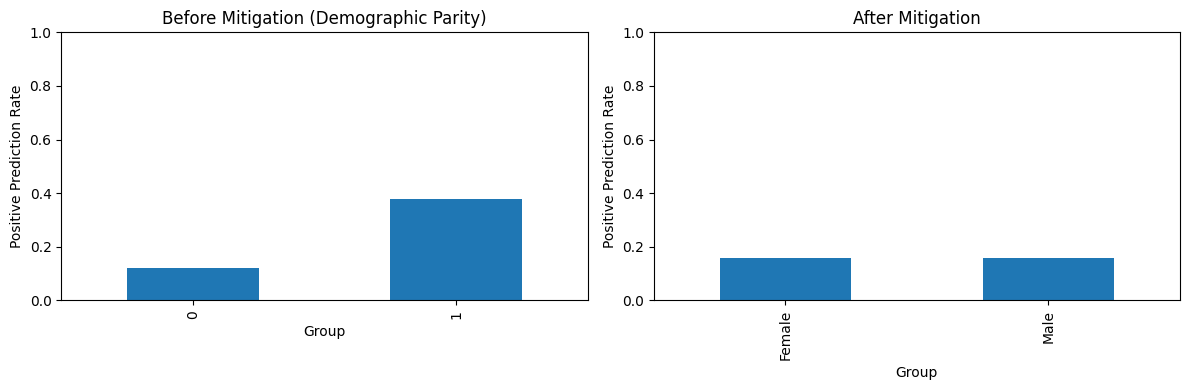

In [208]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Helper to grab the positive prediction rate column, or recompute if needed ---
def _extract_pos_rate(df):
    """Return a Series indexed by group with positive prediction rates from a rates table."""
    if isinstance(df, pd.Series):
        return df  # already a series of rates
    for col in [
        "pos_rate", "selection_rate", "positive_rate",
        "pred_positive_rate", "positive_prediction_rate", "rate"
    ]:
        if col in df.columns:
            return df[col]
    raise KeyError("No positive-rate-like column found.")

def _recompute_pos_rate(groups, y_pred_labels, positive_label=">50K"):
    tmp = pd.DataFrame({
        "group": groups,
        "pred_pos": (y_pred_labels == positive_label).astype(int)
    })
    return tmp.groupby("group")["pred_pos"].mean()

# Try to get BEFORE rates from your rates table; if missing, recompute from predictions
try:
    pr_before = _extract_pos_rate(rates)
except Exception:
    # Ensure we have baseline predictions
    try:
        y_pred  # noqa: F821
    except NameError:
        y_pred = pipe.predict(X_valid_nosens)
    pr_before = _recompute_pos_rate(X_valid[SENSITIVE_FEATURE], y_pred, positive_label=">50K")

# Try to get AFTER rates from your mitigated table; if missing, recompute
try:
    pr_after = _extract_pos_rate(rates_mitigated)
except Exception:
    pr_after = _recompute_pos_rate(X_valid[SENSITIVE_FEATURE], y_pred_mitigated, positive_label=">50K")

# --- Plot side-by-side ---
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
pr_before.plot(kind="bar", ax=ax[0], title="Before Mitigation (Demographic Parity)")
pr_after.plot(kind="bar",  ax=ax[1], title="After Mitigation")

for a in ax:
    a.set_xlabel("Group")
    a.set_ylabel("Positive Prediction Rate")
    a.set_ylim(0, 1)

plt.tight_layout()
plt.show()